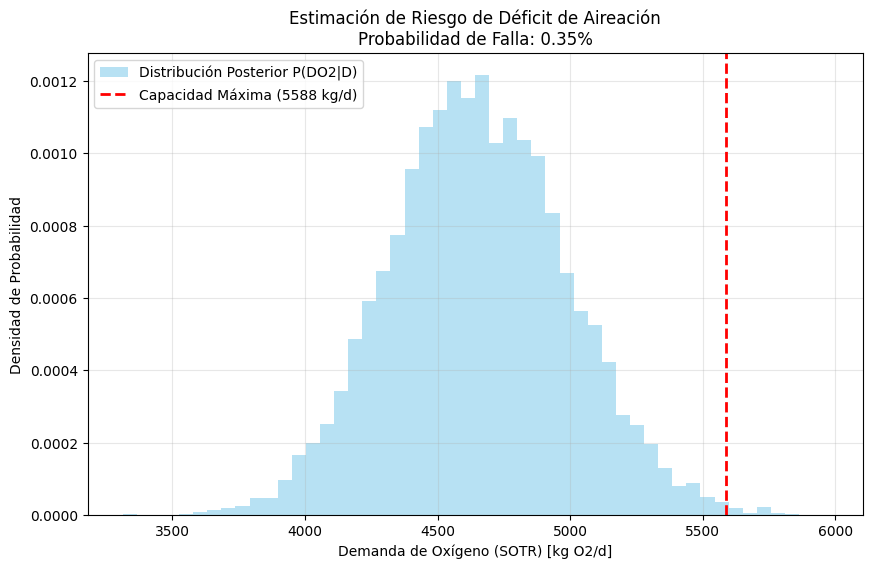

--- Resultados del Análisis de Riesgo ---
Demanda Media Estimada (SOTR): 4655.21 kgO2/d
Desviación Estándar: 334.36 kgO2/d
Capacidad Instalada: 5588.0 kgO2/d
Riesgo Estimado (Probabilidad de Falla): 0.0035 (0.35%)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

# --- 1. Configuración de Parámetros Deterministas (Base: Memoria de Cálculo) ---
# Valores extraídos de la Memoria de Cálculo Rev3
Q_medio_m3_h = 216         # Caudal medio [m3/h]
Q_dia = Q_medio_m3_h * 24      # Caudal diario [m3/d] = 5184

# Concentraciones [g/m3] o [mg/L]
DBO_afluente = 280.0
DBO_efluente = 5.0
N_afluente = 56.0              # N0
N_efluente = 0.0               # N (Asumimos nitrificación completa como en memoria)

# Factores Estequiométricos y de Proceso
f_conv = 0.68                  # Factor conversión DBO5 a DBOu (Memoria ec. 28)
factor_biomasa = 1.42          # O2 consumido por respiración endógena
factor_nitrogeno = 4.57        # O2 consumido por nitrificación
Capacidad_Max_Sopladores = 5588.0 # [kgO2/d] (Capacidad instalada)

# --- 2. Factor de Transferencia (SOTR vs AOR) ---
# La fórmula física calcula la Demanda Biológica (AOR).
# Los sopladores tienen una capacidad nominal (SOTR).
# De la memoria: AOR calc = 2282 kg/d, Requerimiento SOTR = 4657 kg/d.
# Ratio SOTR/AOR ≈ 2.04. Esto incluye alpha, beta, temperatura, elevación.
factor_transferencia = 4657.0 / 2282.7

# --- 3. Definición de Priors (Distribuciones de L y Yobs) ---
np.random.seed(42) # Para reproducibilidad
n_simulaciones = 10000

# A. Distribución de Carga Removida (L)
# L = Q * (DBO_in - DBO_out)
# Media calculada con datos de memoria
mu_L = Q_dia * (DBO_afluente - DBO_efluente) / 1000.0 # [kg DBO5/d]
sigma_L = mu_L * 0.15  # Asumimos 15% de variabilidad (incertidumbre de caudal/carga)

dist_L = np.random.normal(mu_L, sigma_L, n_simulaciones)

# B. Distribución de Rendimiento Observado (Yobs)
# Media de la memoria = 0.563
mu_Yobs = 0.563
sigma_Yobs = mu_Yobs * 0.05 # Asumimos 5% de incertidumbre en parámetros biológicos

dist_Yobs = np.random.normal(mu_Yobs, sigma_Yobs, n_simulaciones)

# C. Error del Modelo (epsilon)
sigma_epsilon = 50.0 # Incertidumbre residual [kgO2/d]
epsilon = np.random.normal(0, sigma_epsilon, n_simulaciones)

# --- 4. Modelo Físico (Likelihood) y Cálculo de Posterior ---
def calcular_demanda_O2(L, Yobs, Q, N0, N, eps):
    """
    Calcula P(DO2|D) basado en la ecuación:
    DO2 = L/f - 1.42*Px(Yobs) + 4.57*Q*(N0-N) + epsilon
    Donde Px = Yobs * L (Producción de lodo base carga removida)
    """
    # Término Carbono (L/f)
    term_carbono = L / f_conv

    # Término Biomasa (Crédito de oxígeno por purga)
    # Px = Yobs * L
    Px = Yobs * L
    term_biomasa = factor_biomasa * Px

    # Término Nitrógeno
    # Carga de N removida [kg/d]
    Carga_N = Q * (N0 - N) / 1000.0
    term_nitrogeno = factor_nitrogeno * Carga_N

    # Demanda Biológica (AOR)
    DO2_biologico = term_carbono - term_biomasa + term_nitrogeno + eps

    return DO2_biologico

# Generar distribución posterior de la demanda
posterior_AOR = calcular_demanda_O2(dist_L, dist_Yobs, Q_dia, N_afluente, N_efluente, epsilon)

# Convertir a Demanda de Campo (SOTR) para comparar con Sopladores
# Si no aplicamos esto, comparamos "peras con manzanas" (Demanda pura vs Capacidad nominal)
posterior_SOTR = posterior_AOR * factor_transferencia

# --- 5. Cálculo del Riesgo (Probabilidad de Falla) ---
# Probabilidad de que la Demanda supere la Capacidad
fallas = posterior_SOTR > Capacidad_Max_Sopladores
probabilidad_falla = np.mean(fallas)

# --- 6. Visualización de Resultados ---
plt.figure(figsize=(10, 6))
plt.hist(posterior_SOTR, bins=50, density=True, alpha=0.6, color='skyblue', label='Distribución Posterior P(DO2|D)')
plt.axvline(Capacidad_Max_Sopladores, color='red', linestyle='--', linewidth=2, label=f'Capacidad Máxima ({int(Capacidad_Max_Sopladores)} kg/d)')
plt.title(f'Estimación de Riesgo de Déficit de Aireación\nProbabilidad de Falla: {probabilidad_falla:.2%}')
plt.xlabel('Demanda de Oxígeno (SOTR) [kg O2/d]')
plt.ylabel('Densidad de Probabilidad')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print(f"--- Resultados del Análisis de Riesgo ---")
print(f"Demanda Media Estimada (SOTR): {np.mean(posterior_SOTR):.2f} kgO2/d")
print(f"Desviación Estándar: {np.std(posterior_SOTR):.2f} kgO2/d")
print(f"Capacidad Instalada: {Capacidad_Max_Sopladores} kgO2/d")
print(f"Riesgo Estimado (Probabilidad de Falla): {probabilidad_falla:.4f} ({probabilidad_falla*100:.2f}%)")

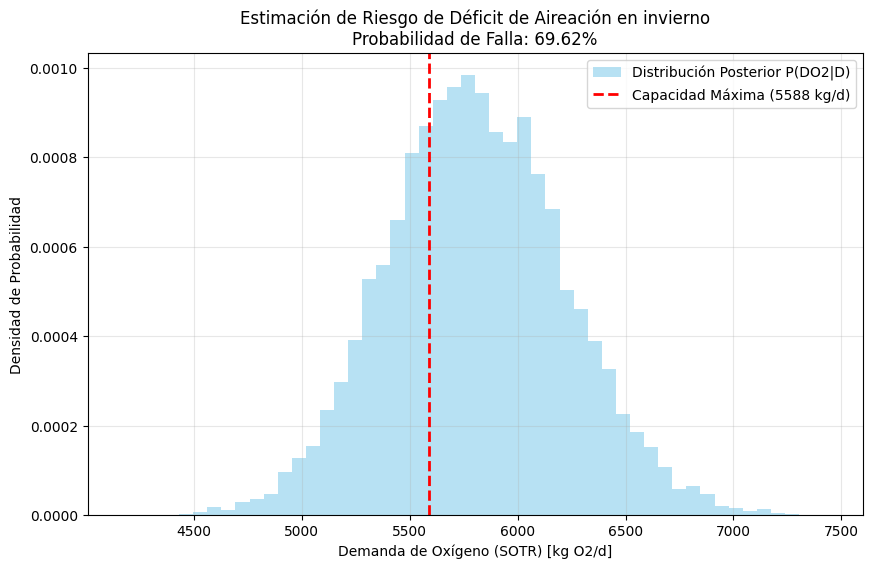

--- Resultados del Análisis de Riesgo ---
Demanda Media Estimada (SOTR): 4655.21 kgO2/d
Desviación Estándar: 334.36 kgO2/d
Capacidad Instalada: 5588.0 kgO2/d
Riesgo Estimado (Probabilidad de Falla): 0.6962 (69.62%)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

# --- 1. Configuración de Parámetros Deterministas (Base: Memoria de Cálculo) ---
# Valores extraídos de la Memoria de Cálculo Rev3
Q_medio_invierno = 270.5           # Caudal medio [m3/h]
Q_dia = Q_medio_invierno * 24      # Caudal diario [m3/d] = 5184

# Concentraciones [g/m3] o [mg/L]
DBO_afluente = 280.0
DBO_efluente = 5.0
N_afluente = 56.0              # N0
N_efluente = 0.37               # N (Nitrogeno de sálida de invierno)

# Factores Estequiométricos y de Proceso
f_conv = 0.68                  # Factor conversión DBO5 a DBOu (Memoria ec. 28)
factor_biomasa = 1.42          # O2 consumido por respiración endógena
factor_nitrogeno = 4.57        # O2 consumido por nitrificación
Capacidad_Max_Sopladores = 5588.0 # [kgO2/d] (Capacidad instalada)

# --- 2. Factor de Transferencia (SOTR vs AOR) ---
# La fórmula física calcula la Demanda Biológica (AOR).
# Los sopladores tienen una capacidad nominal (SOTR).
# De la memoria: AOR calc = 2282 kg/d, Requerimiento SOTR = 4657 kg/d.
# Ratio SOTR/AOR ≈ 2.04. Esto incluye alpha, beta, temperatura, elevación.
factor_transferencia = 4657.0 / 2282.7

# --- 3. Definición de Priors (Distribuciones de L y Yobs) ---
np.random.seed(42) # Para reproducibilidad
n_simulaciones = 10000

# A. Distribución de Carga Removida (L)
# L = Q * (DBO_in - DBO_out)
# Media calculada con datos de memoria
mu_L = Q_dia * (DBO_afluente - DBO_efluente) / 1000.0 # [kg DBO5/d]
sigma_L = mu_L * 0.15  # Asumimos 15% de variabilidad (incertidumbre de caudal/carga)

dist_L = np.random.normal(mu_L, sigma_L, n_simulaciones)

# B. Distribución de Rendimiento Observado (Yobs)
# Media de la memoria = 0.563
mu_Yobs = 0.563
sigma_Yobs = mu_Yobs * 0.05 # Asumimos 5% de incertidumbre en parámetros biológicos

dist_Yobs = np.random.normal(mu_Yobs, sigma_Yobs, n_simulaciones)

# C. Error del Modelo (epsilon)
sigma_epsilon = 50.0 # Incertidumbre residual [kgO2/d]
epsilon = np.random.normal(0, sigma_epsilon, n_simulaciones)

# --- 4. Modelo Físico (Likelihood) y Cálculo de Posterior ---
def calcular_demanda_O2(L, Yobs, Q, N0, N, eps):
    """
    Calcula P(DO2|D) basado en la ecuación:
    DO2 = L/f - 1.42*Px(Yobs) + 4.57*Q*(N0-N) + epsilon
    Donde Px = Yobs * L (Producción de lodo base carga removida)
    """
    # Término Carbono (L/f)
    term_carbono = L / f_conv

    # Término Biomasa (Crédito de oxígeno por purga)
    # Px = Yobs * L
    Px = Yobs * L
    term_biomasa = factor_biomasa * Px

    # Término Nitrógeno
    # Carga de N removida [kg/d]
    Carga_N = Q * (N0 - N) / 1000.0
    term_nitrogeno = factor_nitrogeno * Carga_N

    # Demanda Biológica (AOR)
    DO2_biologico = term_carbono - term_biomasa + term_nitrogeno + eps

    return DO2_biologico

# Generar distribución posterior de la demanda
posterior_AOR = calcular_demanda_O2(dist_L, dist_Yobs, Q_dia, N_afluente, N_efluente, epsilon)

# Convertir a Demanda de Campo (SOTR) para comparar con Sopladores
# Si no aplicamos esto, comparamos "peras con manzanas" (Demanda pura vs Capacidad nominal)
posterior_SOTR_invierno = posterior_AOR * factor_transferencia

# --- 5. Cálculo del Riesgo (Probabilidad de Falla) ---
# Probabilidad de que la Demanda supere la Capacidad
fallas = posterior_SOTR_invierno > Capacidad_Max_Sopladores
probabilidad_falla = np.mean(fallas)

# --- 6. Visualización de Resultados ---
plt.figure(figsize=(10, 6))
plt.hist(posterior_SOTR_invierno, bins=50, density=True, alpha=0.6, color='skyblue', label='Distribución Posterior P(DO2|D)')
plt.axvline(Capacidad_Max_Sopladores, color='red', linestyle='--', linewidth=2, label=f'Capacidad Máxima ({int(Capacidad_Max_Sopladores)} kg/d)')
plt.title(f'Estimación de Riesgo de Déficit de Aireación en invierno\nProbabilidad de Falla: {probabilidad_falla:.2%}')
plt.xlabel('Demanda de Oxígeno (SOTR) [kg O2/d]')
plt.ylabel('Densidad de Probabilidad')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print(f"--- Resultados del Análisis de Riesgo ---")
print(f"Demanda Media Estimada (SOTR): {np.mean(posterior_SOTR):.2f} kgO2/d")
print(f"Desviación Estándar: {np.std(posterior_SOTR):.2f} kgO2/d")
print(f"Capacidad Instalada: {Capacidad_Max_Sopladores} kgO2/d")
print(f"Riesgo Estimado (Probabilidad de Falla): {probabilidad_falla:.4f} ({probabilidad_falla*100:.2f}%)")

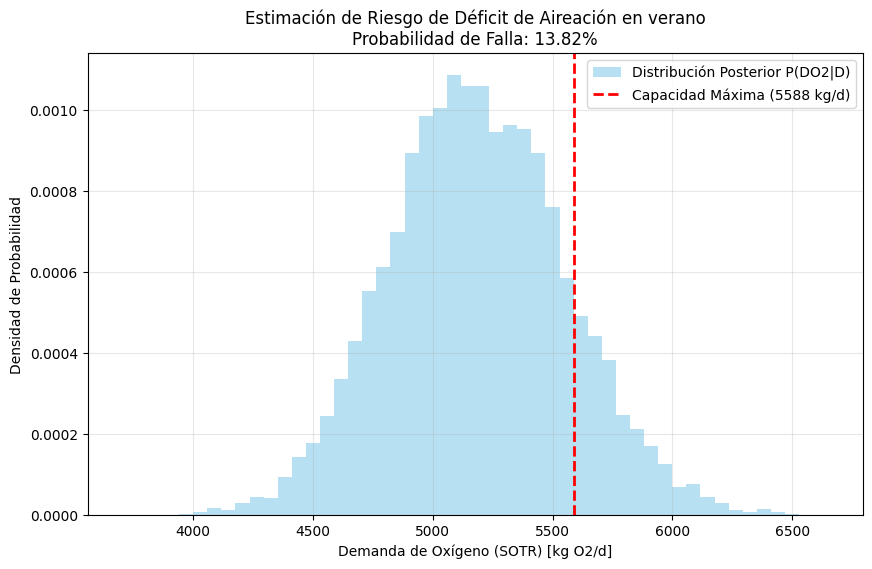

--- Resultados del Análisis de Riesgo ---
Demanda Media Estimada (SOTR): 5186.02 kgO2/d
Desviación Estándar: 370.22 kgO2/d
Capacidad Instalada: 5588.0 kgO2/d
Riesgo Estimado (Probabilidad de Falla): 0.1382 (13.82%)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

# --- 1. Configuración de Parámetros Deterministas (Base: Memoria de Cálculo) ---
# Valores extraídos de la Memoria de Cálculo Rev3
Q_medio_verano = 241.5           # Caudal medio [m3/h]
Q_dia = Q_medio_verano * 24      # Caudal diario [m3/d] = 5184

# Concentraciones [g/m3] o [mg/L]
DBO_afluente = 280.0
DBO_efluente = 5.0
N_afluente = 56.0              # N0
N_efluente = 0.35               # N (Nitrogeno de sálida en verano)

# Factores Estequiométricos y de Proceso
f_conv = 0.68                  # Factor conversión DBO5 a DBOu (Memoria ec. 28)
factor_biomasa = 1.42          # O2 consumido por respiración endógena
factor_nitrogeno = 4.57        # O2 consumido por nitrificación
Capacidad_Max_Sopladores = 5588.0 # [kgO2/d] (Capacidad instalada)

# --- 2. Factor de Transferencia (SOTR vs AOR) ---
# La fórmula física calcula la Demanda Biológica (AOR).
# Los sopladores tienen una capacidad nominal (SOTR).
# De la memoria: AOR calc = 2282 kg/d, Requerimiento SOTR = 4657 kg/d.
# Ratio SOTR/AOR ≈ 2.04. Esto incluye alpha, beta, temperatura, elevación.
factor_transferencia = 4657.0 / 2282.7

# --- 3. Definición de Priors (Distribuciones de L y Yobs) ---
np.random.seed(42) # Para reproducibilidad
n_simulaciones = 10000

# A. Distribución de Carga Removida (L)
# L = Q * (DBO_in - DBO_out)
# Media calculada con datos de memoria
mu_L = Q_dia * (DBO_afluente - DBO_efluente) / 1000.0 # [kg DBO5/d]
sigma_L = mu_L * 0.15  # Asumimos 15% de variabilidad (incertidumbre de caudal/carga)

dist_L = np.random.normal(mu_L, sigma_L, n_simulaciones)

# B. Distribución de Rendimiento Observado (Yobs)
# Media de la memoria = 0.563
mu_Yobs = 0.563
sigma_Yobs = mu_Yobs * 0.05 # Asumimos 5% de incertidumbre en parámetros biológicos

dist_Yobs = np.random.normal(mu_Yobs, sigma_Yobs, n_simulaciones)

# C. Error del Modelo (epsilon)
sigma_epsilon = 50.0 # Incertidumbre residual [kgO2/d]
epsilon = np.random.normal(0, sigma_epsilon, n_simulaciones)

# --- 4. Modelo Físico (Likelihood) y Cálculo de Posterior ---
def calcular_demanda_O2(L, Yobs, Q, N0, N, eps):
    """
    Calcula P(DO2|D) basado en la ecuación:
    DO2 = L/f - 1.42*Px(Yobs) + 4.57*Q*(N0-N) + epsilon
    Donde Px = Yobs * L (Producción de lodo base carga removida)
    """
    # Término Carbono (L/f)
    term_carbono = L / f_conv

    # Término Biomasa (Crédito de oxígeno por purga)
    # Px = Yobs * L
    Px = Yobs * L
    term_biomasa = factor_biomasa * Px

    # Término Nitrógeno
    # Carga de N removida [kg/d]
    Carga_N = Q * (N0 - N) / 1000.0
    term_nitrogeno = factor_nitrogeno * Carga_N

    # Demanda Biológica (AOR)
    DO2_biologico = term_carbono - term_biomasa + term_nitrogeno + eps

    return DO2_biologico

# Generar distribución posterior de la demanda
posterior_AOR = calcular_demanda_O2(dist_L, dist_Yobs, Q_dia, N_afluente, N_efluente, epsilon)

# Convertir a Demanda de Campo (SOTR) para comparar con Sopladores
# Si no aplicamos esto, comparamos "peras con manzanas" (Demanda pura vs Capacidad nominal)
posterior_SOTR = posterior_AOR * factor_transferencia

# --- 5. Cálculo del Riesgo (Probabilidad de Falla) ---
# Probabilidad de que la Demanda supere la Capacidad
fallas = posterior_SOTR > Capacidad_Max_Sopladores
probabilidad_falla = np.mean(fallas)

# --- 6. Visualización de Resultados ---
plt.figure(figsize=(10, 6))
plt.hist(posterior_SOTR, bins=50, density=True, alpha=0.6, color='skyblue', label='Distribución Posterior P(DO2|D)')
plt.axvline(Capacidad_Max_Sopladores, color='red', linestyle='--', linewidth=2, label=f'Capacidad Máxima ({int(Capacidad_Max_Sopladores)} kg/d)')
plt.title(f'Estimación de Riesgo de Déficit de Aireación en verano\nProbabilidad de Falla: {probabilidad_falla:.2%}')
plt.xlabel('Demanda de Oxígeno (SOTR) [kg O2/d]')
plt.ylabel('Densidad de Probabilidad')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print(f"--- Resultados del Análisis de Riesgo ---")
print(f"Demanda Media Estimada (SOTR): {np.mean(posterior_SOTR):.2f} kgO2/d")
print(f"Desviación Estándar: {np.std(posterior_SOTR):.2f} kgO2/d")
print(f"Capacidad Instalada: {Capacidad_Max_Sopladores} kgO2/d")
print(f"Riesgo Estimado (Probabilidad de Falla): {probabilidad_falla:.4f} ({probabilidad_falla*100:.2f}%)")

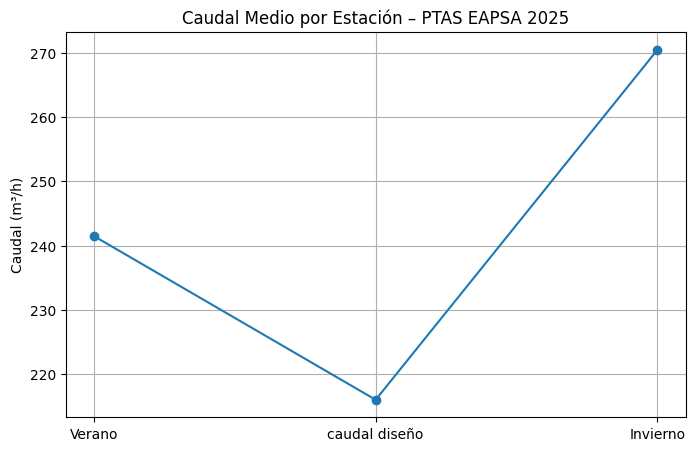

In [ ]:
import matplotlib.pyplot as plt

meses = ["Verano", "caudal diseño", "Invierno"]
caudales = [241.5, 216, 270.5]

plt.figure(figsize=(8,5))
plt.plot(meses, caudales, marker='o')
plt.title("Caudal Medio por Estación – PTAS EAPSA 2025")
plt.ylabel("Caudal (m³/h)")
plt.grid(True)
plt.show()


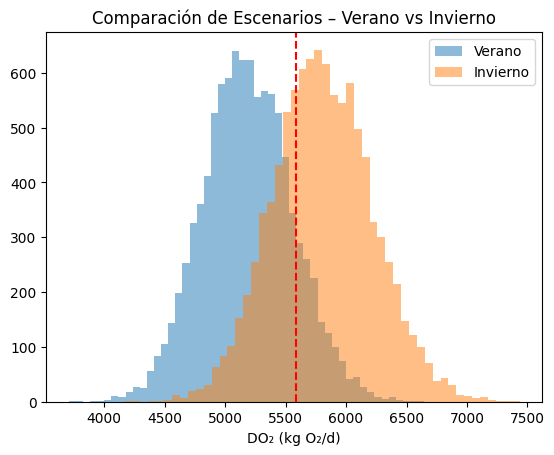

In [ ]:
plt.hist(posterior_SOTR, bins=50, alpha=0.5, label="Verano")
plt.hist(posterior_SOTR_invierno, bins=50, alpha=0.5, label="Invierno")
plt.axvline(5588, color='red', linestyle='--')
plt.title("Comparación de Escenarios – Verano vs Invierno")
plt.xlabel("DO₂ (kg O₂/d)")
plt.legend()
plt.show()

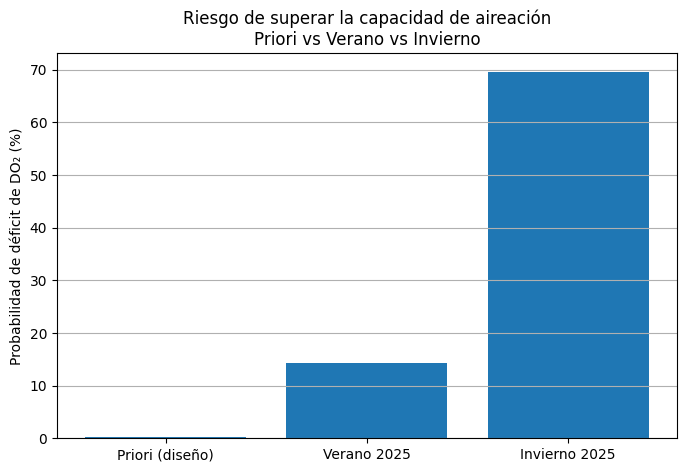

In [ ]:
import matplotlib.pyplot as plt

# Probabilidades de riesgo que obtuviste
p_priori   = 0.32   # %
p_verano   = 14.31  # %
p_invierno = 69.62  # %

escenarios = ["Priori (diseño)", "Verano 2025", "Invierno 2025"]
riesgos = [p_priori, p_verano, p_invierno]

plt.figure(figsize=(8,5))
plt.bar(escenarios, riesgos)
plt.ylabel("Probabilidad de déficit de DO₂ (%)")
plt.title("Riesgo de superar la capacidad de aireación\nPriori vs Verano vs Invierno")
plt.grid(axis="y")

# Para guardar la figura:
# plt.savefig("Figura_Riesgo_Priori_Verano_Invierno.png", dpi=300, bbox_inches="tight")

plt.show()
